In [30]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import adfuller
import itertools as it
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
import math

# 1.Загрузка данных

In [31]:
df = pd.read_csv('stock_data.csv')
df = df[['date','ticker','close','volume']]

In [32]:
df1 = df[df['date']>'2011-01-01']
df2 = df1[df1['date']<'2021-01-01']  # df2 это дата с начала 2020 по начало 2021 год
df3 = df[df['date']>'2021-01-01']    # df3 это дата с начала 2021 по начало 2022 год
df3 = df3[df3['date']<'2022-01-01']   # df4 это дата с начала 2022 
df4 = df[df['date']>'2022-01-01']

# 2. Отбор активов: 2011.01.01 - 2021.01.01

### Отбор относительно ликвидности и торгуемости

In [33]:
volume = df2[['ticker','volume']].groupby(by='ticker').sum().reset_index()
tickers_by_volume = volume[volume['volume'] > np.quantile(volume['volume'], 0.95)]['ticker'].to_numpy()
print(f'Количество активов отобранных относителельно наилучшей ликвидности: {len(set(tickers_by_volume))}')


tickers_by_days = df2['ticker'].value_counts()[df2['ticker'].value_counts() > max(df2['ticker'].value_counts())*0.95].index.to_numpy()
print(f'Количество активов отобранных относителельно количества торгуемых дней: {len(set(tickers_by_days))}')
                                             # ограничение чтобы торги акциями были хотя бы 99% от максимальной
    
    
tickers = list(set(tickers_by_days) & set(tickers_by_volume))
print(f'Итогвое количество отобранных активов: {len(tickers)}')


Количество активов отобранных относителельно наилучшей ликвидности: 206
Количество активов отобранных относителельно количества торгуемых дней: 1169
Итогвое количество отобранных активов: 148


In [34]:
#Создаю датафрейм с несколькими обозначениями колоннок для удобства работы с активами

def multi_column_df(df, tickers):
    d = {} 
    for i in tqdm(tickers):
        d[f"{i}"] = df[df['ticker'] == i].set_index('date') 
        d[f"{i}"] = d[f"{i}"].drop(['ticker'],axis=1)

    df = pd.concat(d,join = 'inner', axis=1) #объединяю чтобы даты совпадали
    return df

df2 = multi_column_df(df2, tickers)
df2.head(4)

  0%|          | 0/148 [00:00<?, ?it/s]

sz002027            sh600635            sh600300              \
              close     volume    close     volume    close      volume   
date                                                                      
2011-06-22     1.53  1484591.0     3.38  6629572.0     4.67   4313202.0   
2011-06-23     1.56  3151991.0     3.39  8065559.0     4.74   4795703.0   
2011-07-25     1.59  5296323.0     3.31  6929586.0     5.45  34167452.0   
2011-08-04     1.61  1296643.0     3.30  3198046.0     5.49   9643321.0   

           sh600048             sh600143             ... sz002146              \
              close      volume    close     volume  ...    close      volume   
date                                                 ...                        
2011-06-22     4.12  28481848.0     7.92  1816269.0  ...     3.25   4855926.0   
2011-06-23     4.16  25525032.0     8.05  2085714.0  ...     3.25   4973490.0   
2011-07-25     4.01  41198380.0     8.78  5072460.0  ...     3.00  10296498.0   
2011-08-04     4.16  10764211.0     8.82  3065507.0  ...     3.07   4143079.0   

           sz000830             sh600688            sz000725              \
              close      volume    close     volume    close      volume   
date                                                                       
2011-06-22     5.21   9960172.0     2.83  2511119.0     2.43  58297456.0   
2011-06-23     5.27  13887885.0     2.88  4517977.0     2.45  80233024.0   
2011-07-25     5.48  15972343.0     2.88  4880399.0     2.35  86387816.0   
2011-08-04     5.42   6656933.0     2.76  5130065.0     2.30  43119448.0   

           sh600703             
              close     volume  
date                            
2011-06-22     5.82  2300152.0  
2011-06-23     5.89  3393721.0  
2011-07-25     6.22  6423266.0  
2011-08-04     5.94  3253387.0  

[4 rows x 296 columns]

## Проверка коинтеграции активов

### Отбор относительно того, что активы нестационарным сами по себе

In [35]:
tick_adf = []
for i in tqdm(tickers):
    result = adfuller(df2[f'{i}']['close']) #Проверяю является ли ADF статистика больше критических значений
                         #Проверяю является ли p-значение больше критического чтобы проверить нулевую гипотезу о 
                                # нестационарном временном ряду
    if result[1] > 0.05 and result[0]>result[4]['1%']:
        tick_adf.append(i)
print(f'Количество нестационарных активов: {len(tick_adf)}')


  0%|          | 0/148 [00:00<?, ?it/s]

Количество нестационарных активов: 118


### Отбор относительно того, что линейная комбинация активов стационарна

In [36]:
print(f'Количество сочетаний активов: {math.factorial(len(tick_adf))/(math.factorial(len(tick_adf)-2)*2)}')

Количество сочетаний активов: 6903.0


In [37]:
tick_Engle_Granger = []
for i in tqdm(it.combinations(tick_adf, 2)):
    result = coint(df2[f'{i[0]}']['close'].to_numpy(), df2[f'{i[1]}']['close'].to_numpy())  
    if result[1] < 0.05: # проверяю что существует такой параметр при котором линейная комбинация двух временных рядов
        tick_Engle_Granger.append(i)  # стационарна
print(f'Количество коинтегрируемых пар активов: {len(tick_Engle_Granger)}')

0it [00:00, ?it/s]

Количество коинтегрируемых пар активов: 867


In [38]:
gammas = []  #поиск параметра, относительно которого линейная комбинация двух активов стационарна
for i in tick_Engle_Granger:
    ols = sm.OLS(df2[i[0]]['close'].to_numpy(), df2[i[1]]['close'].to_numpy())
    ols_fit = ols.fit()
    g = ols_fit.params[0]
    gammas.append(g) #Получаю параметр на обучающей выборке при котором лин комбинация стационарна

comb_tick_gamma = pd.DataFrame()
comb_tick_gamma['comb_tick'] = tick_Engle_Granger
comb_tick_gamma['gamma'] = gammas

# 3. Реализация стратегии на тестовой выборке: 2021.01.01 - 2022.01.01 

### Стратегия

Относительно стратегии полученная гамма может быть как положительная, так и отрицательная, так что отныне работа представленна только относительно полученной разницы между активами. То есть, другими словами, разница по модулю между активами - теперь новый актив, с которым осуществлеяется торговля. Соответсвенно так как мы привели спред к нормальному распределению, то стратегию покупки и продажи следующая:



* Покупка при $z_{t}$ $< −2.00$  
* Шорт при $z_{t}$ $> 2.00$  
* Закрытие шорта при if $z_{t}$ $< 0.75$  
* Закрытие длинной позиции if $z_{t}$ $> −0.50$  



### Подготовка тестового датасета

In [39]:
df3 = multi_column_df(df3, tick_adf) #Создаю более удобный датафрейм с отобранными активами

  0%|          | 0/118 [00:00<?, ?it/s]

In [40]:
def get_spred_z(train, test, tickers_with_gamma):
    #3 df, train and test мультииндексные
    z_spread = {}
    for index, row in tqdm(tickers_with_gamma.iterrows()): #интерация по совокупностям активов
        
        spread_df2 = train[row['comb_tick'][0]]['close'].to_numpy() - row['gamma'] * train[row['comb_tick'][1]]['close'].to_numpy() 
        # n-size
        d = pd.DataFrame()
        z_family = []
        date = []
        spread_family = []

        for i in test.index: #интерация по датам
            date_df = test[test.index == i]
            spread_now = date_df[row['comb_tick'][0]]['close'].to_numpy() - row['gamma']*date_df[row['comb_tick'][1]]['close'].to_numpy() # 1-size
            spread_df2 = spread_df2[1:] #удаляю последние 1 дней #окно
            spread_df2 = np.append(spread_df2, spread_now)

            z = (spread_now - np.mean(spread_df2)) / np.std(spread_df2)
            z_family = np.append(z_family, z)
   

            date.append(i)
            spread_family.append(spread_now[0])

        d['date'] = date
        d['spread'] = spread_family
        d['z'] = z_family

        z_spread[f"{row['comb_tick'][0]} & {row['comb_tick'][1]}"] = d.set_index('date')
    return z_spread

In [41]:
stat_abr = get_spred_z(df2, df3, comb_tick_gamma)
stat_abr = pd.concat(stat_abr, axis=1)

0it [00:00, ?it/s]

### Модель осуществления торговли и принятия решений

In [42]:
def model(date, tickers, spread, z): 
            date_active = []

            profit_in_moment = 0
            profit_by_day = []
            profit_in_percent = 0
            profit_by_day_in_percent = []

            situation = 'waiting to short or long'

            position = 0
            just_open = False #Счетчик, который показывает что позицию только что открыли 

            spending = 0 
            spent = []

            in_pos_check = 0
            in_pos = []

            time_position_open = 0

            d = pd.DataFrame()

            for i in range(len(date)):

                #Реализация стратегии

                if z[i] < -1.85 and situation == 'waiting to short or long':

                    position = spread[i] 
                    situation = 'waiting for -0.5 to sell'
                    in_pos_check = 1

                    just_open = True

                elif z[i] > -0.7 and situation ==  'waiting for -0.5 to sell':
                    profit_in_moment = spread[i] - position
                    situation = 'waiting to short or long'

                    in_pos_check = 0
                    time_position_open = 0

                elif z[i] > 1.85 and situation == 'waiting to short or long':

                    position = spread[i]
                    situation = 'waiting for 0.5 to buy'
                    in_pos_check = 1

                    just_open = True

                elif z[i] < 0.7 and situation ==  'waiting for 0.5 to buy':
                    profit_in_moment = position - spread[i]
                    situation = 'waiting to short or long'

                    in_pos_check = 0
                    time_position_open = 0

                if in_pos_check == 1 and situation == 'waiting for 0.5 to buy':  #Проверять сколько я получил прибыли
                    profit_in_moment = position - spread[i]

                elif in_pos_check == 1 and situation == 'waiting for -0.5 to sell':
                    profit_in_moment = spread[i] - position

                if just_open == True:     #Проверять сколько я затратил денег для получения такой прибыли
                    spending = np.abs(position)


                #Защита 50 убыточных дней    

                if in_pos_check == 1 and situation != 'waiting to short or long': #если наблюдается лосс в течении 50 дней, то 
                                                                                # мы выходим из позиции
                    time_position_open += 1 * int(profit_in_moment<0)

                    if np.sum(np.array(profit_by_day[-50:])<0) >= 35 and time_position_open >= 50:

                        situation = 'full stop'
                        in_pos_check = 0


                #Stop-lose - если мы ушли в минус на 5 процентов от позиции, то работает стоп лосс

                if position != 0 and (position + profit_in_moment)/position <= 0.95:
                    situation = 'full stop'
                    in_pos_check = 0


                #Если актив начинает снова работать относительно распределения, то даём алгоритму продолжить

                if (z[i] < 1.4 or z[i] > -1.4 ) and situation == 'full stop':
                    situation = 'waiting to short or long'




                spent.append(spending)

                spending = 0
                just_open = False

                profit_by_day.append(profit_in_moment)
                date_active.append(date[i])
                in_pos.append(in_pos_check)



                if np.sum(spent)==0:
                    profit_in_percent = 0
                else:
                    profit_in_percent = np.sum(profit_by_day)/np.sum(spent)

                profit_by_day_in_percent.append(profit_in_percent)



            d['date'] = date_active
            d['profit'] = profit_by_day #чистая
            d['position'] = in_pos
            d['spent'] = spent
            d['profit_daily_percent'] = profit_by_day_in_percent


            return d

### Реализация торговли

In [43]:
profit_loss = {}
for ticker, new_df in tqdm(stat_abr.groupby(level=0, axis = 1)): #short_stat это итерация по каждому активу со спредом и z
    new_df = new_df[f'{ticker}']
    profit_loss[f"{ticker}"] = model(np.array(new_df.index), ticker, new_df['spread'].to_numpy(), new_df['z'].to_numpy()).set_index('date')

profit_loss = pd.concat(profit_loss, axis=1)  

  0%|          | 0/867 [00:00<?, ?it/s]

### Расчет показателей эффективности инвестиционного портфеля

In [44]:
final_df = pd.DataFrame()
final_df['profit'] = np.array([0]*len(profit_loss.index))
final_df['spent'] = np.array([0]*len(profit_loss.index))
final_df['profit_daily_percent'] = np.array([0]*len(profit_loss.index))

for tickers, new_df in tqdm(profit_loss.groupby(level=0, axis = 1)): #short_stat это итерация по каждому активу со спредом и z
    final_df['profit'] += new_df[f'{tickers}']['profit'].to_numpy()
    final_df['spent'] += new_df[f'{tickers}']['spent'].to_numpy()
    final_df['profit_daily_percent'] += new_df[f'{tickers}']['profit_daily_percent'].to_numpy()


  0%|          | 0/867 [00:00<?, ?it/s]

In [45]:
R_B = 2.358 #безрисковая доходность Китая на 18.08.22
profitability = np.sum(final_df['profit'])/np.sum(final_df['spent'])
Sharp_ratio = (profitability - R_B) / np.std(final_df['profit_daily_percent'])
Other_ratio =  np.sum(final_df['profit']) / min(final_df['profit'])
print(f'Реализация алгоритма: \nДоходность: {profitability}, \nПоказатель Шарпа: {Sharp_ratio}, \nОтношение накопленной доходности к максимальной просадке {Other_ratio}')

Реализация алгоритма: 
Доходность: 1.3426799627833859, 
Показатель Шарпа: -0.0006462839457536491, 
Отношение накопленной доходности к максимальной просадке -580.4171545829079


### Отбор активов для проверочного датасета относительно r^2 и показателя Шарпа

In [46]:
evaluation = {}
for tick, new_df in tqdm(profit_loss.groupby(level=0, axis = 1)):
    if np.sum(new_df[f'{tick}']['profit']) == 0 or np.sum(new_df[f'{tick}']['spent']) == 0 or np.sum(new_df[f'{tick}']['spent']) == 0:
        continue
    else:
        profitability = np.sum(new_df[f'{tick}']['profit'])/np.sum(new_df[f'{tick}']['spent'])
        R_B = 2.358   #безрисковая доходность Китая на 18.08.22 с поправкой на 130 дней торгуемых
    
        d = pd.DataFrame()
        Sharp_ratio = (profitability - R_B) / np.std(new_df[f'{tick}']['profit_daily_percent'])
        
        if min(new_df[f'{tick}']['profit']) == 0:
        
            Other_ratio = np.inf * np.sign(np.sum(new_df[f'{tick}']['profit']))
        else:      
            Other_ratio =  np.sum(new_df[f'{tick}']['profit']) / min(new_df[f'{tick}']['profit'])    
            #отношение накопленной доходности к максимальной просадке
            
            
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(new_df[f'{tick}']['profit'].to_numpy(), np.arange(0,len(new_df[f'{tick}']['profit'].to_numpy())))
    
    d['r_squared'] = [r_value**2]
    
    d['Sharp_ratio'] = [Sharp_ratio]
    d['Other_ratio'] = [Other_ratio]
    evaluation[f"{tick}"] = d
evaluation = pd.concat(evaluation, axis=1)      

  0%|          | 0/867 [00:00<?, ?it/s]

In [47]:
evaluation

sh600008 & sh600256                         sh600008 & sh600516              \
            r_squared Sharp_ratio Other_ratio           r_squared Sharp_ratio   
0            0.303449    0.445813  -22.051605            0.083379   -8.303131   

              sh600008 & sh600688                         sh600008 & sh601006  \
  Other_ratio           r_squared Sharp_ratio Other_ratio           r_squared   
0   11.593644            0.631905     2.53098  -450.32011             0.59443   

   ... sz300185 & sh601899 sz300185 & sz000009                          \
   ...         Other_ratio           r_squared Sharp_ratio Other_ratio   
0  ...           10.367302            0.001486   -0.184777   28.636663   

  sz300185 & sz000667                         sz300185 & sz000776              \
            r_squared Sharp_ratio Other_ratio           r_squared Sharp_ratio   
0            0.501473    1.846424 -108.530324            0.353244    3.284029   

               
  Other_ratio  
0         inf  

[1 rows x 2346 columns]

In [48]:
final_list = []
d = {}
sharp = []
for tick, new_df in tqdm(evaluation.groupby(level=0, axis = 1)):
    if new_df[f'{tick}']['Sharp_ratio'][0] > 1 and new_df[f'{tick}']['r_squared'][0] > 0.60 :
        final_list.append(tick)
        sharp.append(new_df[f'{tick}']['Sharp_ratio'][0])
print(f'Количество активов, подходящих для торговли: {len(final_list)}') 

  0%|          | 0/782 [00:00<?, ?it/s]

Количество активов, подходящих для торговли: 115


In [49]:
arr = np.array(sharp).argsort()
final_list = np.array(final_list)[arr][-20:]

# 4. Реализация на проверочном датасете: 2022-01-01 - 2022-05-11

### Подготовка датасета:

In [50]:
df4 = multi_column_df(df4, tick_adf)

  0%|          | 0/118 [00:00<?, ?it/s]

In [51]:
stat_abr = get_spred_z(df2, df4, comb_tick_gamma)
stat_abr = pd.concat(stat_abr, axis=1)
stat_abr = stat_abr[final_list]

0it [00:00, ?it/s]

### Реализация симуляции торговли

In [52]:
profit_loss = {}
for ticker, new_df in tqdm(stat_abr.groupby(level=0, axis = 1)): #short_stat это итерация по каждому активу со спредом и z
    new_df = new_df[f'{ticker}']
    profit_loss[f"{ticker}"] = model(np.array(new_df.index), ticker, new_df['spread'].to_numpy(), new_df['z'].to_numpy()).set_index('date')

profit_loss = pd.concat(profit_loss, axis=1)  

  0%|          | 0/20 [00:00<?, ?it/s]

### Подсчёт итоговых показателей инвестиционного портфеля

In [53]:
final_df = pd.DataFrame()
final_df['profit'] = np.array([0]*len(profit_loss.index))
final_df['spent'] = np.array([0]*len(profit_loss.index))
final_df['profit_daily_percent'] = np.array([0]*len(profit_loss.index))

for tickers, new_df in tqdm(profit_loss.groupby(level=0, axis = 1)): #short_stat это итерация по каждому активу со спредом и z
    final_df['profit'] += new_df[f'{tickers}']['profit'].to_numpy()
    final_df['spent'] += new_df[f'{tickers}']['spent'].to_numpy()
    final_df['profit_daily_percent'] += new_df[f'{tickers}']['profit_daily_percent'].to_numpy()


  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
R_B = 2.358 * 130/365
profitability = np.sum(final_df['profit'])/np.sum(final_df['spent'])
Sharp_ratio = (profitability - R_B) / np.std(final_df['profit_daily_percent'])
Other_ratio =  np.sum(final_df['profit']) / min(final_df['profit'])
print(f'Реализация алгоритма: \nДоходность: {profitability}, \nПоказатель Шарпа: {Sharp_ratio}, \nОтношение накопленной доходности к максимальной просадке {Other_ratio}')

Реализация алгоритма: 
Доходность: 7.606974088190928, 
Показатель Шарпа: 0.6056505915351473, 
Отношение накопленной доходности к максимальной просадке -410.08676411489614


### Графическая илюстрация портефеля

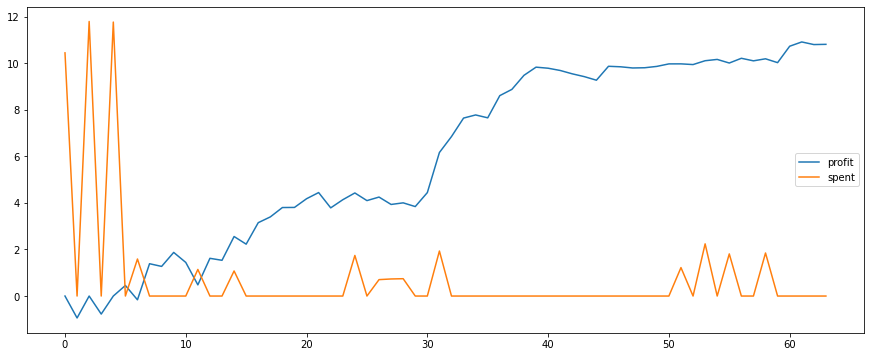

In [55]:

plt.plot(final_df['profit'].to_numpy(), label=f'profit' )
plt.plot(final_df['spent'].to_numpy(), label=f'spent' )
fig = plt.gcf()
fig.set_size_inches(15, 6, forward=True)
plt.legend()
plt.show()

### Графическая илюстрация работы алгоритма на 50 активах

In [56]:
summary = {}
for tick, new_df in tqdm(profit_loss.groupby(level=0, axis = 1)):
    summary[tick] = new_df[tick]['profit'].sum()

  0%|          | 0/20 [00:00<?, ?it/s]

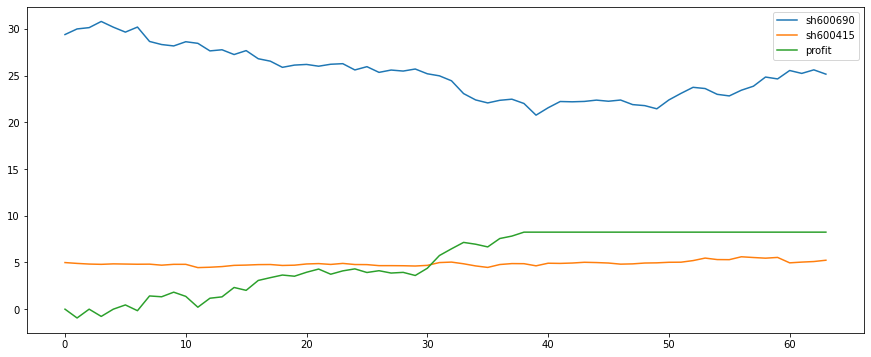

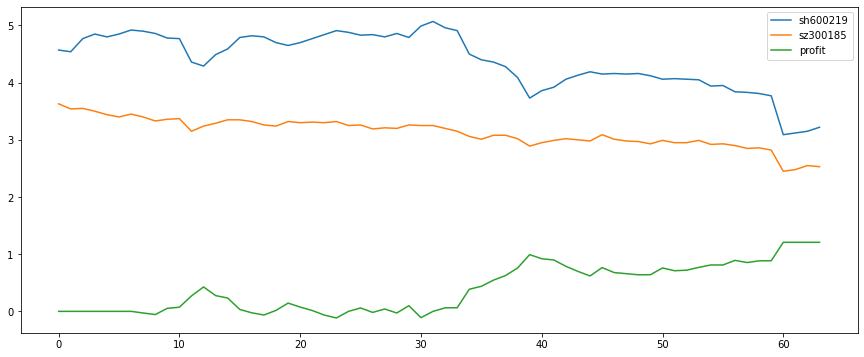

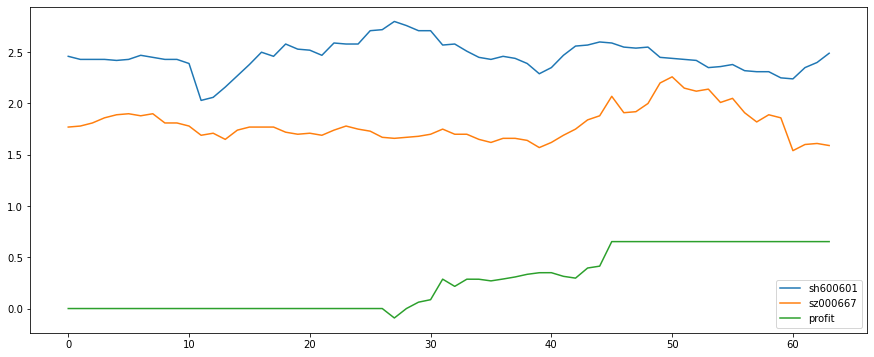

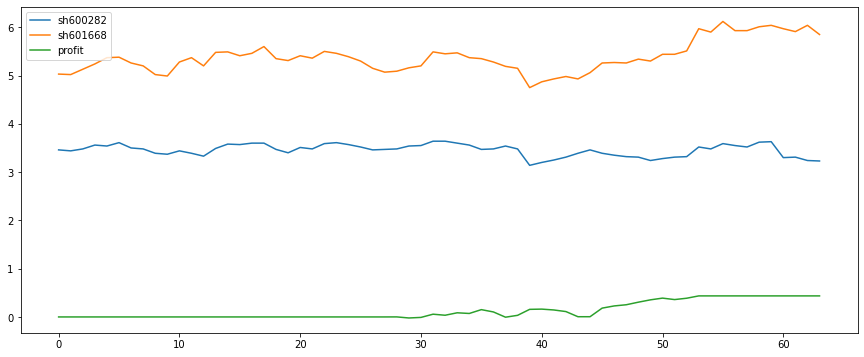

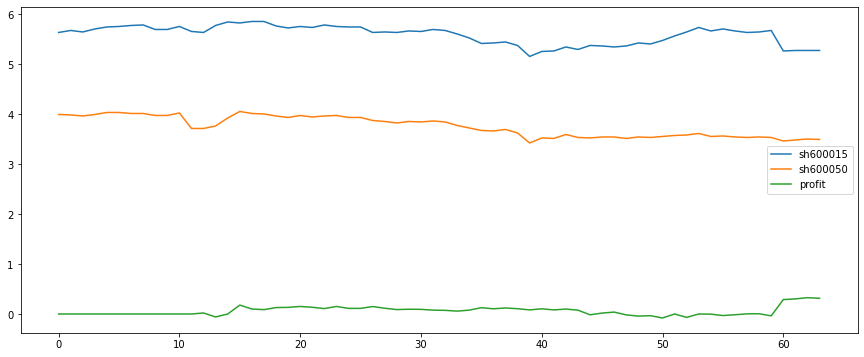

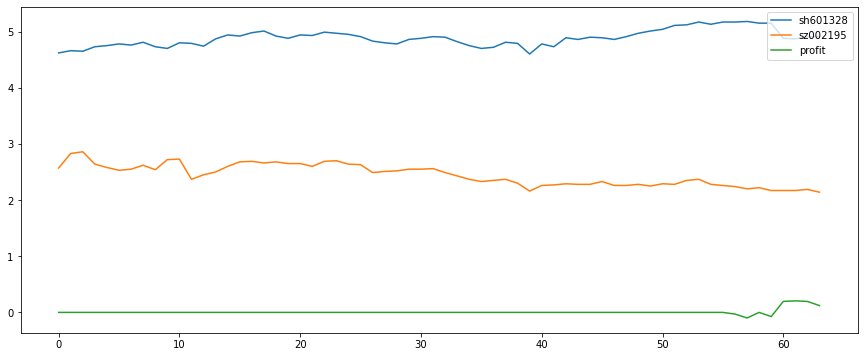

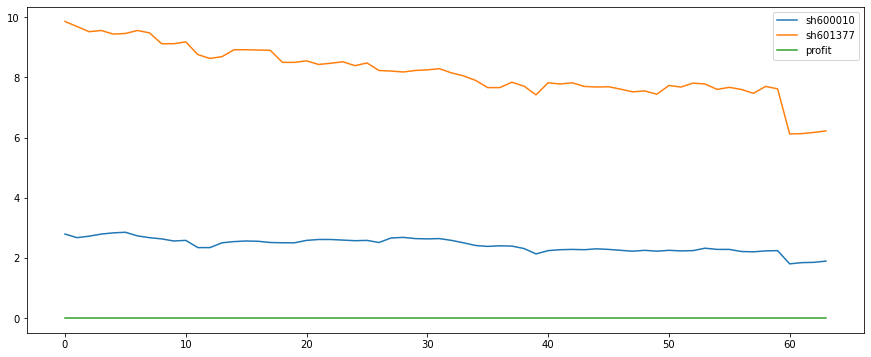

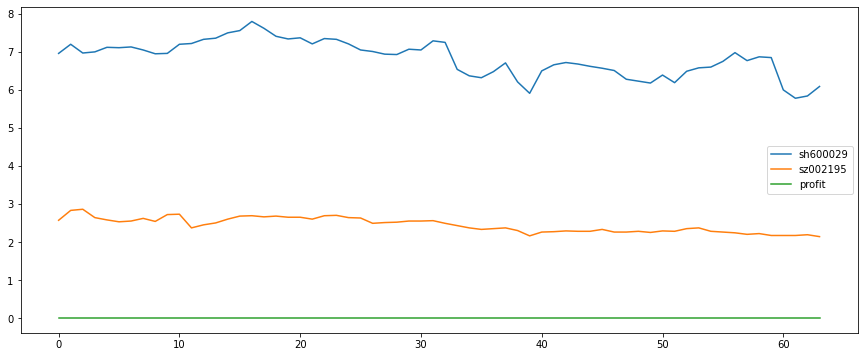

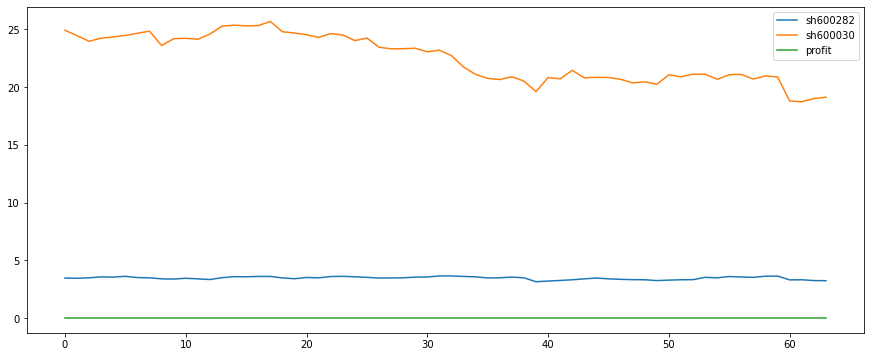

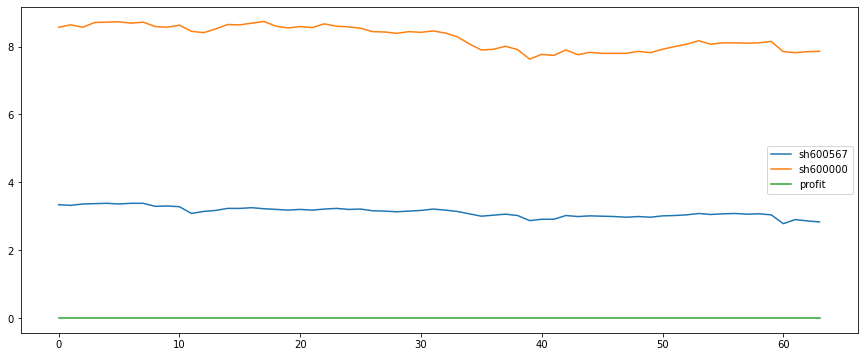

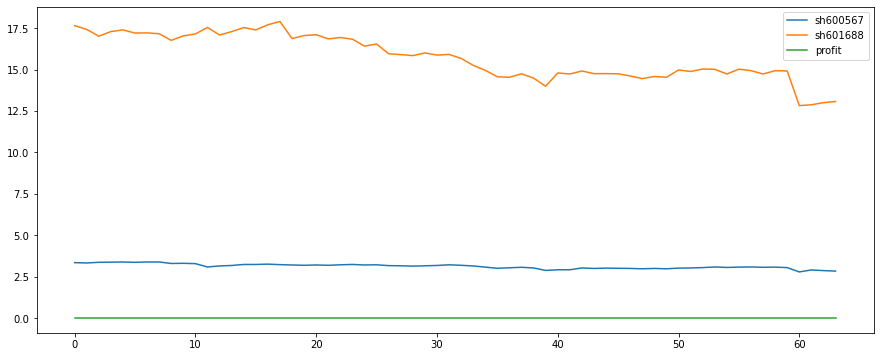

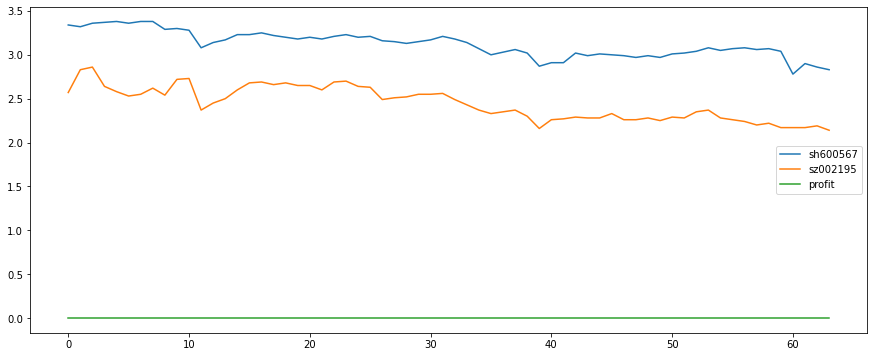

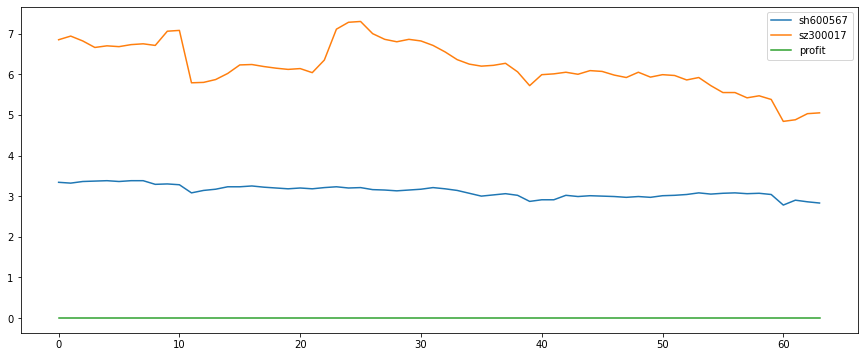

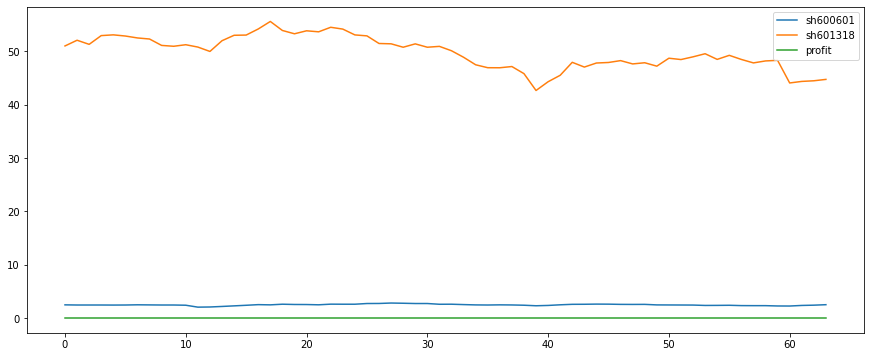

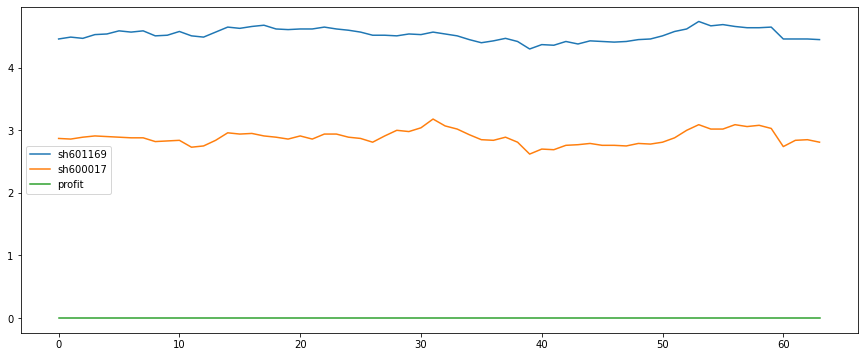

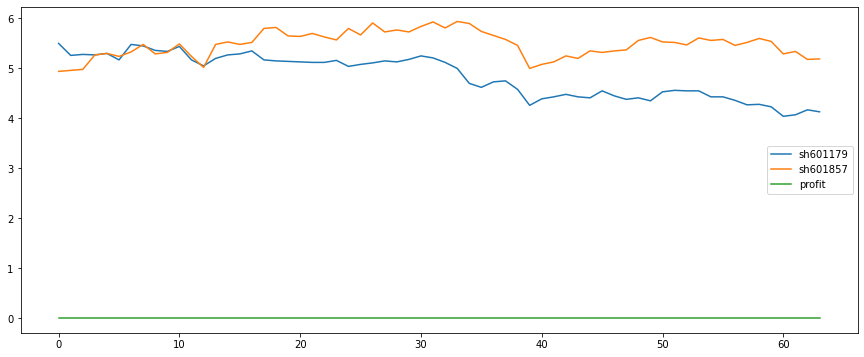

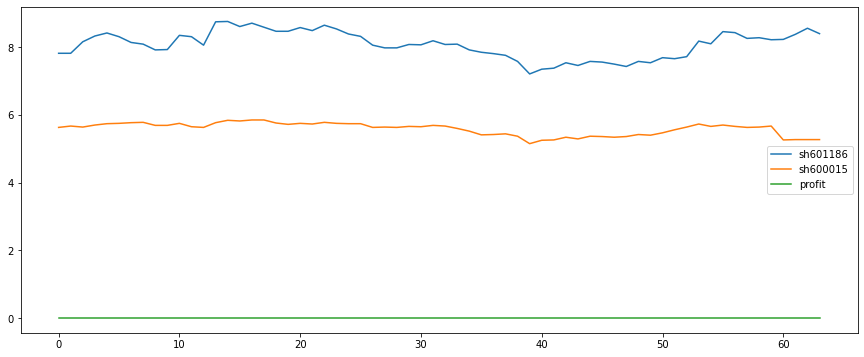

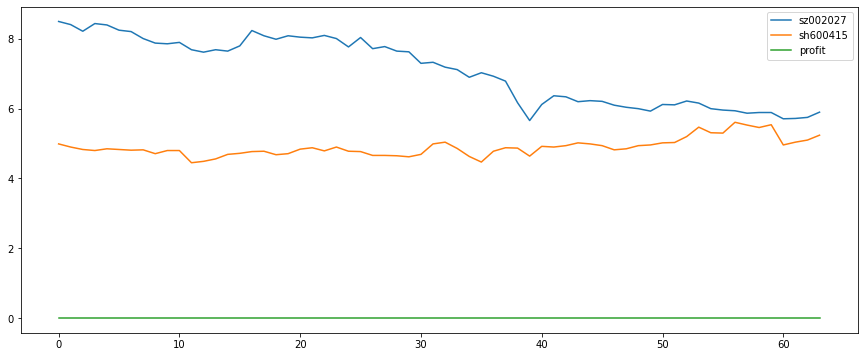

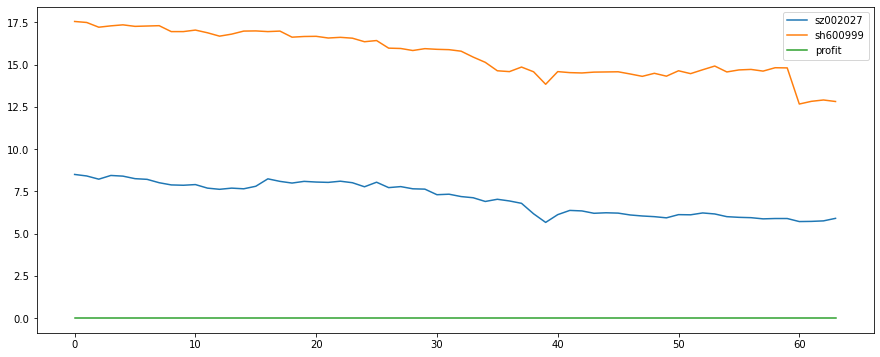

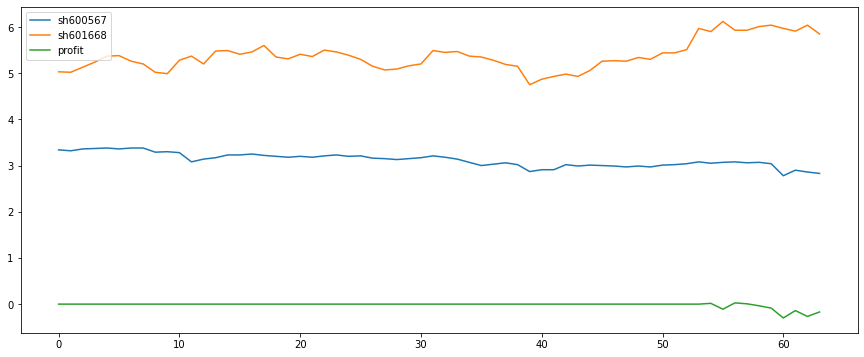

In [57]:
top_actives = sorted(summary, key=summary.get, reverse=True)[0:50]
for i in top_actives:
    actives = i.split(' & ')
    plt.plot(df4[actives[0]]['close'].to_numpy(), label=f'{actives[0]}' )
    plt.plot(df4[actives[1]]['close'].to_numpy(), label=f'{actives[1]}')
    plt.plot(profit_loss[f'{i}']['profit'].to_numpy(), label= 'profit')
    fig = plt.gcf()
    fig.set_size_inches(15, 6, forward=True)
    plt.legend()
    plt.show()
    